In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [3]:
import perceval as pcvl

In [4]:
# Utils
def herald(output_state):
    state_list = []
    for m in str(output_state):
        if m.isdigit():
            state_list.append(int(m))

    h1 = {2: 1, 3: 0, 8: 1, 9: 0, 7: 1, 4: 0}
    h2 = {2: 0, 3: 1, 8: 1, 9: 0, 7: 1, 4: 0}
    h3 = {2: 1, 3: 0, 8: 0, 9: 1, 7: 1, 4: 0}
    h4 = {2: 0, 3: 1, 8: 0, 9: 1, 7: 1, 4: 0}
    h5 = {2: 1, 3: 0, 8: 1, 9: 0, 7: 0, 4: 1}
    h6 = {2: 0, 3: 1, 8: 1, 9: 0, 7: 0, 4: 1}
    h7 = {2: 1, 3: 0, 8: 0, 9: 1, 7: 0, 4: 1}
    h8 = {2: 0, 3: 1, 8: 0, 9: 1, 7: 0, 4: 1}
    #GHZ- : h1, h4, h6, h7
    #GHZ+ : h2, h3, h5, h8
    h = [h1, h4, h6, h7]

    output_dict = {}
    for idx, bit in enumerate(state_list):
        if bit > 0:
            output_dict[idx] = 1
        if bit == 0:
            output_dict[idx] = 0

    output_h = {2: output_dict[2], 3: output_dict[3], 8: output_dict[8],
                9: output_dict[9], 7: output_dict[7], 4: output_dict[4]}

    for hi in h:
        if hi == output_h:
            return True

    return False


def output_state_sign(operator, output_state):
    measurement_output = {'0': -1, '1': 1}

    signs_dict = {i: measurement_output for i in range(3)}

    sign = 1
    for n, val in enumerate(operator):
        if val != 'I':
            sign = sign * signs_dict[n][output_state[n]]

    return int(sign)


def get_gk(histo, projector, operator):
    output_bit_string = ["".join(i) for i in list(itertools.product(['0', '1'], repeat=3))]
    gk_i = 0
    for outcome in output_bit_string:
        gk_i += histo[projector][projector][outcome] * output_state_sign(operator, outcome)
    return gk_i


def get_result(output_state):
    state_list = []
    for m in str(output_state):
        if m.isdigit():
            state_list.append(int(m))

    s = ''

    for i in [0, 5, 10]:
        if int(state_list[i]) == 0 and int(state_list[i + 1]) == 1:
            s += '1'
        if int(state_list[i]) == 1 and int(state_list[i + 1]) == 0:
            s += '0'

    if len(s) < 3:
        return None
    else:
        return s

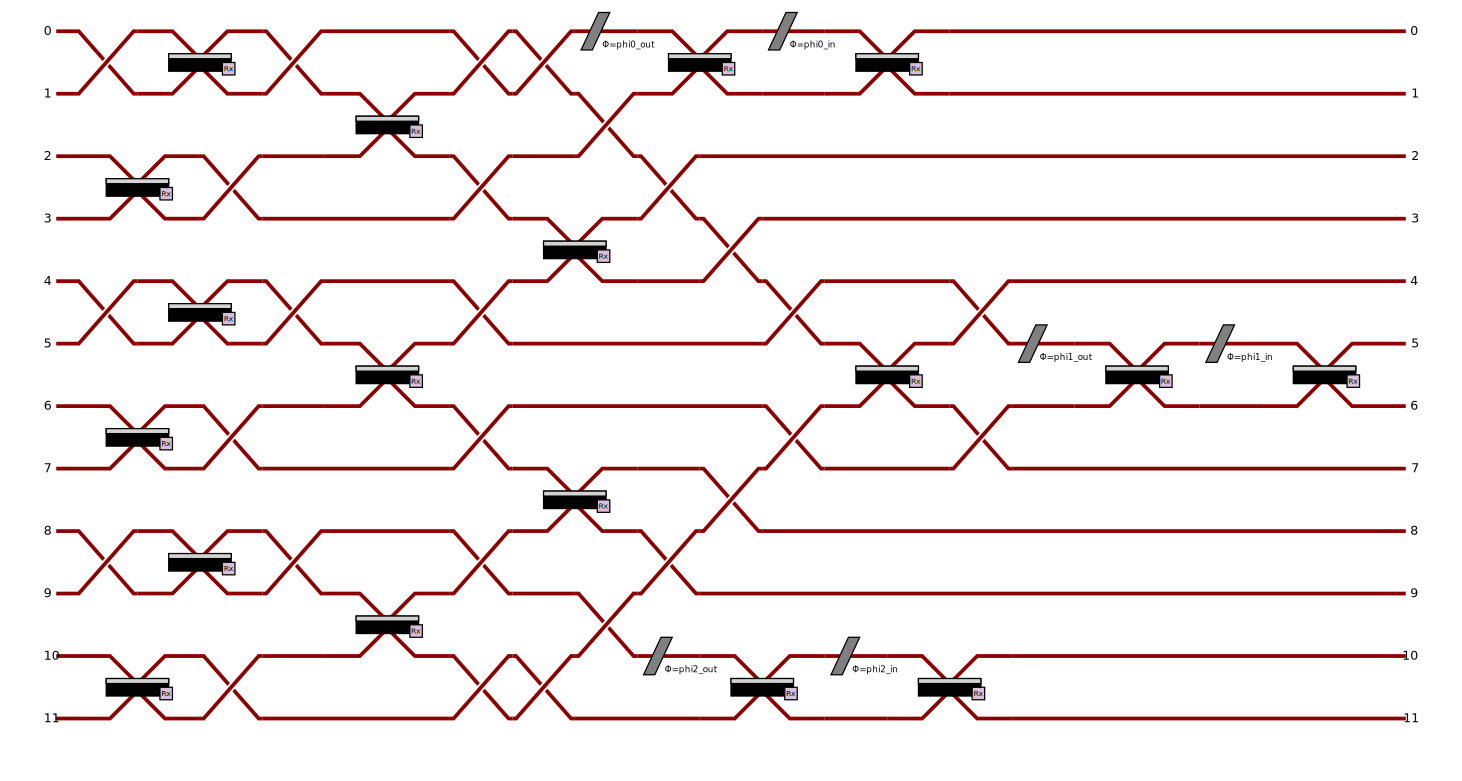

In [5]:
# Photonic circuit generator
class GhzFactory:
    # Construct n-mode cyclic interferometer.
    def __init__(self):

        self.outcome = ["".join(i) for i in list(itertools.product(['0', '1'], repeat=3))]

        self.circuit = pcvl.Circuit(m=12, name="3_GHZ_Factory")
        
        self.circuit.add(0, pcvl.PERM([1, 0]))
        self.circuit.add(4, pcvl.PERM([1, 0]))
        self.circuit.add(8, pcvl.PERM([1, 0]))

        # Create 3 Bell state |phi^+> (post-selected)
        for i in range(0, 12, 2):
            self.circuit.add(i, pcvl.BS())
        for i in range(0, 12, 2):
            self.circuit.add(i, pcvl.PERM([1, 0]))
        for i in range(1, 11, 4):
            self.circuit.add(i, pcvl.BS())
        for i in range(0, 12, 2):
            self.circuit.add(i, pcvl.PERM([1, 0]))

        self.circuit.add(3, pcvl.BS())
        self.circuit.add(7, pcvl.BS())

        for i in range(0, 5):
            self.circuit.add((i, i + 1), pcvl.PERM([1, 0]))
        for i in range(11, 6, -1):
            self.circuit.add((i - 1, i), pcvl.PERM([1, 0]))
        self.circuit.add((5, 6), pcvl.BS())

        self.circuit.add(0, pcvl.PS(phi=pcvl.P(f"phi{0}_out")))
        self.circuit.add((0, 1), pcvl.BS())
        self.circuit.add(0, pcvl.PS(phi=pcvl.P(f"phi{0}_in")))
        self.circuit.add((0, 1), pcvl.BS())

        self.circuit.add((4, 5), pcvl.PERM([1, 0]))
        self.circuit.add((6, 7), pcvl.PERM([1, 0]))

        self.circuit.add(5, pcvl.PS(phi=pcvl.P(f"phi{1}_out")))
        self.circuit.add((5, 6), pcvl.BS())
        self.circuit.add(5, pcvl.PS(phi=pcvl.P(f"phi{1}_in")))
        self.circuit.add((5, 6), pcvl.BS())

        self.circuit.add(10, pcvl.PS(phi=pcvl.P(f"phi{2}_out")))
        self.circuit.add((10, 11), pcvl.BS())
        self.circuit.add(10, pcvl.PS(phi=pcvl.P(f"phi{2}_in")))
        self.circuit.add((10, 11), pcvl.BS())

        # Measurement defines the 1-qubit Pauli projectors in the path-encoded scheme.
        self.measurement = dict()

        self.measurement['sigmaz'] = [0 + np.pi / 2, np.pi / 2]
        self.measurement['sigmay'] = [np.pi / 2 + np.pi / 2, np.pi / 2]
        self.measurement['sigmax'] = [0 + np.pi / 2, np.pi]
        self.measurement['Id'] = [0, np.pi]

photonic_circuit_fordisplay = GhzFactory()
pcvl.pdisplay(photonic_circuit_fordisplay.circuit)

In [6]:
# Running an experiment on a remote QPU using Quandela Cloud
def compute(qpu: str = 'sim:altair',
            token_qcloud='<your_personal_token>',
            nsamples: int = 1e6,
            projector: tuple = ('sigmaz', 'sigmaz', 'sigmaz')):

    photonic_circuit = GhzFactory()

    # set up the int. and ext. phases of the path tomography to implement the projective measurement
    list_of_phases = []
    reconfigurable_phase_shifter = photonic_circuit.circuit.get_parameters()
    for path_encoded_qubit in projector:
        list_of_phases.append(photonic_circuit.measurement[path_encoded_qubit])
    c = 0
    for phi in list_of_phases:
        reconfigurable_phase_shifter[c].set_value(phi[0])
        reconfigurable_phase_shifter[c + 1].set_value(phi[1])
        c += 2

    # Acquire data on Quandela Cloud
    remote_qpu = pcvl.RemoteProcessor(qpu, token_qcloud)

    remote_qpu.set_circuit(photonic_circuit.circuit)
    remote_qpu.with_input(pcvl.BasicState([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]))
    remote_qpu.min_detected_photons_filter(6)   

    sampler = pcvl.algorithm.Sampler(remote_qpu, max_shots_per_call=int(1e12))
    job = sampler.sample_count(nsamples)
    sv_out = job["results"]

    # Data processing & normalization
    empirical_table = {projector: {}}

    for output_state in sv_out:
        heralded = herald(output_state)
        if heralded:
            result = get_result(output_state)
            if result:
                if result not in empirical_table:
                    empirical_table[projector][result] = sv_out[output_state]
                # Add the probabilility to the result if it has already been created.
                else:
                    empirical_table[projector][result] += sv_out[output_state]

    for outcome in photonic_circuit.outcome:
        if outcome not in empirical_table[projector]:
            empirical_table[projector][outcome] = 0.0

    norm_factor = np.sum([empirical_table[projector][x] for x in photonic_circuit.outcome])
    dict_normed = {}
    for outcome in photonic_circuit.outcome:
        dict_normed[outcome] = empirical_table[projector][outcome] / norm_factor

    empirical_table[projector] = dict_normed

    return empirical_table


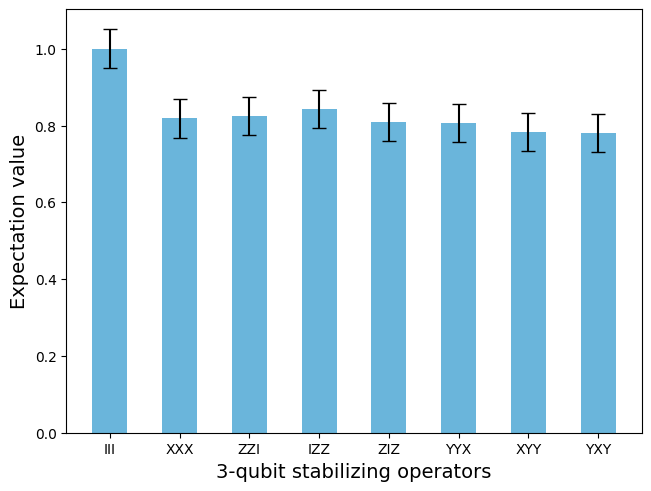

F = 0.833145119755666


In [7]:
# Measure fidelity of the generated state using the stabilizer group
from loggings import TOKEN as token

platform = "sim:ascella"
# token = "<your_personal_token>"
nb_of_samples = 1e9

projectors = [('sigmaz', 'sigmaz', 'sigmaz'),
              ('sigmax', 'sigmax', 'sigmax'),
              ('sigmay', 'sigmay', 'sigmax'),
              ('sigmax', 'sigmay', 'sigmay'),
              ('sigmay', 'sigmax', 'sigmay')]

histo = {}
for p in projectors:
    histo[p] = compute(qpu=platform,
                       token_qcloud=token,
                       nsamples=nb_of_samples,
                       projector=p)

operators = {'III': ('sigmaz', 'sigmaz', 'sigmaz'),
             'XXX': ('sigmax', 'sigmax', 'sigmax'),
             'ZZI': ('sigmaz', 'sigmaz', 'sigmaz'),
             'IZZ': ('sigmaz', 'sigmaz', 'sigmaz'),
             'ZIZ': ('sigmaz', 'sigmaz', 'sigmaz'),
             'YYX': ('sigmay', 'sigmay', 'sigmax'),
             'XYY': ('sigmax', 'sigmay', 'sigmay'),
             'YXY': ('sigmay', 'sigmax', 'sigmay')
             }

fig, ax = plt.subplots(constrained_layout=True)
for op in operators:
    ax.bar(op, abs(get_gk(operators[op], op)), color='#6ab5db', width=0.5, yerr=0.05, capsize=5)

ax.set_xlabel('3-qubit stabilizing operators', fontsize=14)
ax.set_ylabel('Expectation value', fontsize=14)
plt.show()

print(f"F = {1 / 8 * sum([abs(get_gk(histo, operators[op], op)) for op in operators])}")
